## Временные ряды. Поиск аномалий и особенные случаи обработки

Содержание:
* [Time Series "Brent 2010-2019"](#brent)
* [Дифференцирование и ресемплинг рядов](#diffs)
* [Подготовка входных наборов данных](#datasets)
* [Train test splitting](#ttspl)
* [Тестирование моделей из списка с глубиной прогнозирования h=1](#modelbulding)
* [Тест горизонта h = 10](#h10)
* [Пробуем улучшить модель](#mref)

## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. Cделайте ее перрасчет (ресемплинг) в представление по неделям.
4. Постройте модель предсказания 1-й точки от текущей (h=1).
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

## Time Series "Brent 2010-2019"
<left><a class="anchor" id="brent"></a><left>
Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import os
import statsmodels.api as sm
import warnings
from sklearn.preprocessing import StandardScaler
import catboost as catb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, KFold

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])

In [3]:
brent_data.drop(['year', 'month', 'dayofmonth',
                 'quarter', 'dayofyear','weekofyear', 'dayofweek',
                 'is_holiday', 'is_prev_holiday','is_next_holiday'],
                 axis=1,inplace=True)

In [4]:
# Отношение стоимости рубля в доллару
rub_doll = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.index = pd.to_datetime(rub_doll.index)

# Отношение стоимости рубя к евро
rub_e = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.index = pd.to_datetime(rub_e.index)

Text(0.5,0,'date')

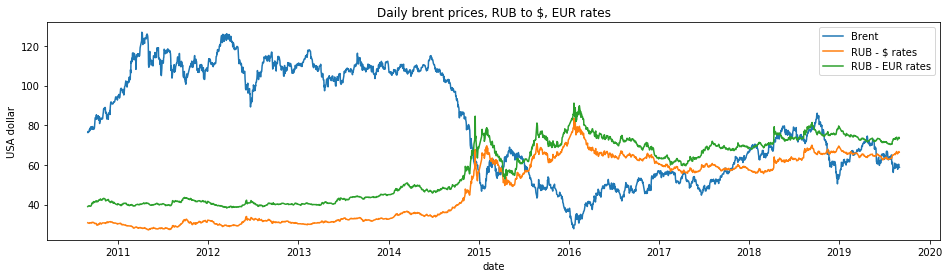

In [9]:
plt.figure(figsize=(16,4))
plt.plot(brent_data['Значение'], label='Brent ')
plt.plot(rub_doll['curs'], label='RUB - $ rates')
plt.plot(rub_e['curs'], label='RUB - EUR rates')
plt.ylabel('USA dollar')
plt.title('Daily brent prices, RUB to $, EUR rates')
plt.legend()
plt.xlabel('date')

## Дифференцирование и ресемплинг рядов
<left><a class="anchor" id="diffs"></a><left>

Наиболее интересным для и интерпретируемым у этого ряда является поведение его первых разностей
Построим их и посмотрим на аномалии этой части нашей модели.

In [10]:
# Первые разности Brent
d_brent_data = brent_data['Значение'].values[1:] - brent_data['Значение'].values[:-1]
brent_data['brent_diff1'] = 0
brent_data['brent_diff1'] =  brent_data['brent_diff1'].astype('float') 
brent_data['brent_diff1'].values[1:] = d_brent_data

# Первые разности RUB - $
d_rub_doll = rub_doll['curs'].values[1:] - rub_doll['curs'].values[:-1]
rub_doll['rub_doll_diff1'] = 0
rub_doll['rub_doll_diff1'] = rub_doll['rub_doll_diff1'].astype('float')
rub_doll['rub_doll_diff1'].values[1:] = d_rub_doll

# Первые разности RUB - EUR
d_rub_e = rub_e['curs'].values[1:] - rub_e['curs'].values[:-1]
rub_e['rub_euro_diff1'] = 0
rub_e['rub_euro_diff1'] = rub_e['rub_euro_diff1'].astype('float')
rub_e['rub_euro_diff1'].values[1:] = d_rub_e

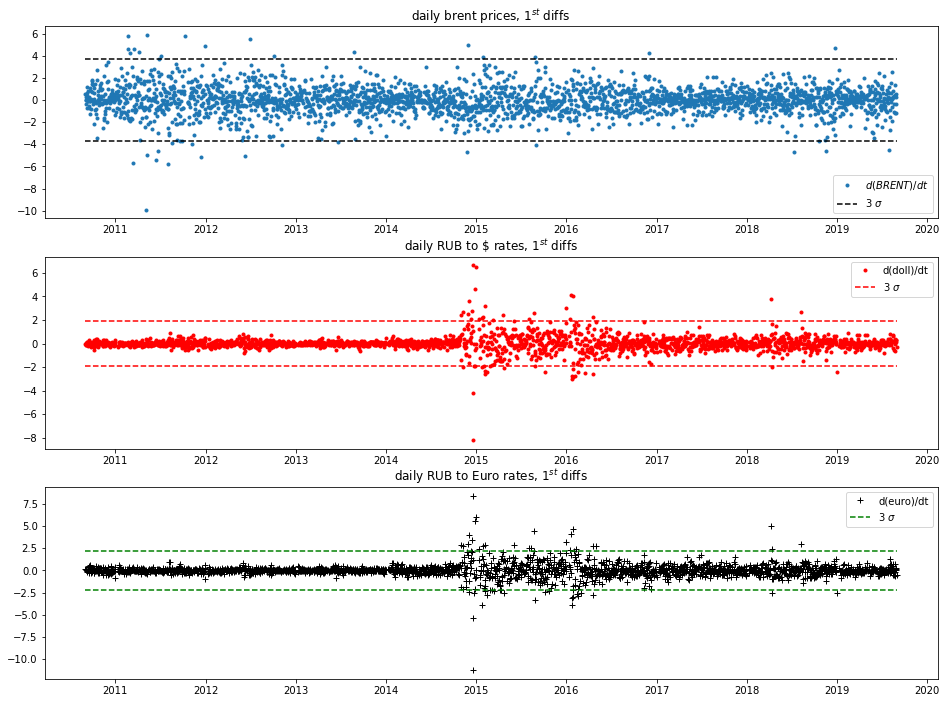

In [11]:
# Граница 3-х сигм
s_brent = np.var(d_brent_data)**0.5 * 3
s_rub = np.var(d_rub_doll)**0.5 * 3
s_rube = np.var(d_rub_e)**0.5 * 3

plt.figure(figsize=(16,12))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='$d(BRENT)/dt$')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 $\sigma$')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.title('daily brent prices, $1^{st}$ diffs ')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 $\sigma$')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.title('daily RUB to \$ rates, $1^{st}$ diffs ')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 $\sigma$')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')
plt.legend()
plt.title('daily RUB to Euro rates, $1^{st}$ diffs ')
plt.show()

# Списки выбросов
ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

Графики показывают наличие выбросов за пределы 3 сигм (в сумме 131), причем характер выбросов цены brent достаточно слабо согласуется с валютными котировками 

In [12]:
print(ind_anomal_brent.shape[0])
print(ind_anomal_rubl_d.shape[0])
print(ind_anomal_rubl_e.shape[0])

38
46
47


In [13]:
# Ресемплинг данных по недельным значениям

brent_data_w = brent_data.resample('W').mean()
rub_doll_data_w = rub_doll.resample('W').mean()
rub_euro_data_w = rub_e.resample('W').mean()

In [14]:
brent_data_w['rub_doll_rate'] = rub_doll_data_w['curs']
brent_data_w['rub_euro_rate'] = rub_euro_data_w['curs']
brent_data_w['rub_euro_diff1'] = rub_euro_data_w['rub_euro_diff1']
brent_data_w['rub_doll_diff1'] = rub_doll_data_w['rub_doll_diff1']

brent_data_w.fillna(method='pad', inplace=True)

График первых разностей по недельному ресемплингу показывает значительное уменьшение количества выбросов (в сумме 24), снизилось количество случайных биений, на что в значительной степени повлияло усреднение семплов. Такие данные позволят построить более достоверную модель.

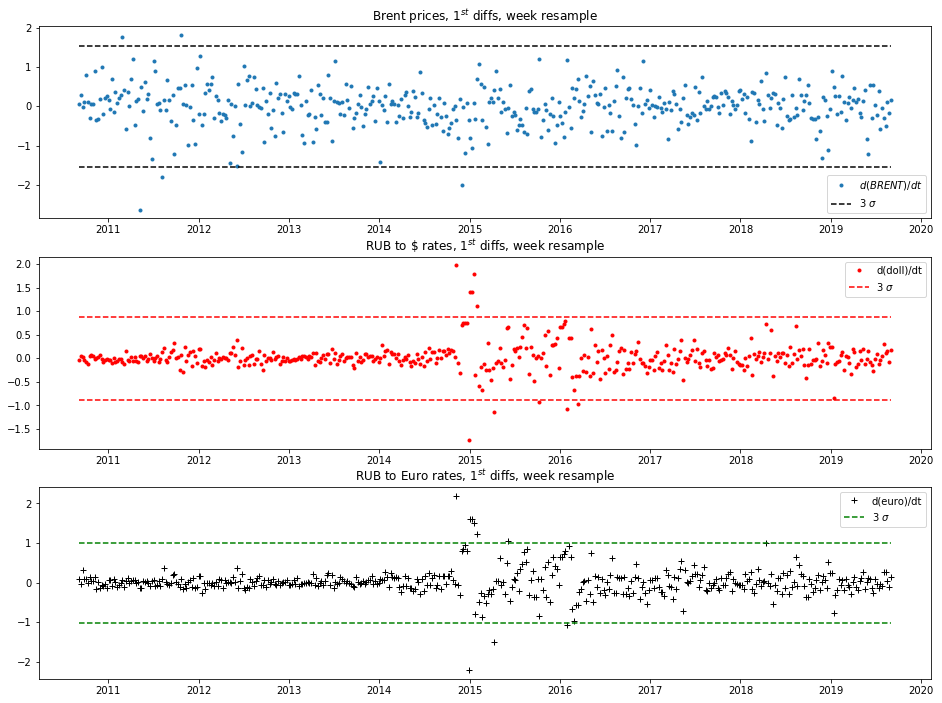

In [15]:
# Граница 3-х сигм
s_brent = np.var(brent_data_w['brent_diff1'])**0.5 * 3
s_rub = np.var(brent_data_w['rub_doll_diff1'])**0.5 * 3
s_rube = np.var(brent_data_w['rub_euro_diff1'])**0.5 * 3

plt.figure(figsize=(16,12))
plt.subplot(3,1,1)
plt.plot(brent_data_w.iloc[:].index,brent_data_w['brent_diff1'],'.', label='$d(BRENT)/dt$')
plt.plot(brent_data_w.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 $\sigma$')
plt.plot(brent_data_w.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.title('Brent prices, $1^{st}$ diffs, week resample')
plt.legend()

plt.subplot(3,1,2)
plt.plot(brent_data_w.iloc[:].index,brent_data_w['rub_doll_diff1'],'.r', label='d(doll)/dt')
plt.plot(brent_data_w.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 $\sigma$')
plt.plot(brent_data_w.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.title('RUB to \$ rates, $1^{st}$ diffs, week resample')
plt.legend()

plt.subplot(3,1,3)
plt.plot(brent_data_w.iloc[:].index,brent_data_w['rub_euro_diff1'],'+k', label='d(euro)/dt')
plt.plot(brent_data_w.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 $\sigma$')
plt.plot(brent_data_w.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')
plt.legend()
plt.title('RUB to Euro rates, $1^{st}$ diffs, week resample')
plt.show()

# Списки выбросов
ind_anomal_brent = np.where( abs(brent_data_w['brent_diff1'])>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(brent_data_w['rub_doll_diff1'])>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(brent_data_w['rub_euro_diff1'])>s_rube)[0]

In [16]:
print(ind_anomal_brent.shape[0])
print(ind_anomal_rubl_d.shape[0])
print(ind_anomal_rubl_e.shape[0])

5
10
9


## Подготовка входных наборов данных
<left><a class="anchor" id="datasets"></a><left>

Запишем итоговую систему признаков и проведем ее анализ. За основу используем горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1), также для дальнейшего сравнения используем несколько более глубокий горизонт h=10

In [56]:
# Подготовка входного набора данных с учетом горизонта (h) и глубины (p) прогнозирования
def get_scaled_h_data(data, target_colname, h, p=0):
    
    scl_x = StandardScaler() # Скалирование признаков (сохраняется для обратного скалирования)
    scl_target = StandardScaler() # Скалирование целевой переменной
    
    X = data.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    
    target = data[target_colname].values[h+p:].reshape((data.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    
    return X, y, scl_x, scl_target


# Получение входного набора данных
h1=1
h10=10

X, y, scl_x, scl_target = get_scaled_h_data(brent_data_w, 'Значение', h1)
X_10, y_10, scl_x_10, scl_target_10 = get_scaled_h_data(brent_data_w, 'Значение', h10)
# X_10p5, y_10p5, scl_x_10p5, scl_target_10p5 = get_scaled_h_data(brent_data_w, 'Значение', h10, p=5)

## Train test splitting
<left><a class="anchor" id="ttspl"></a><left>


Построение модели начинаем с выделения тестовой части ряда. Для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Разделение реализуется по индексу, который задает дату между обучающей и тестовой выборками.

In [18]:
# Функция для сплиттинга

def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Дата') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Дата') >  split_date].copy()

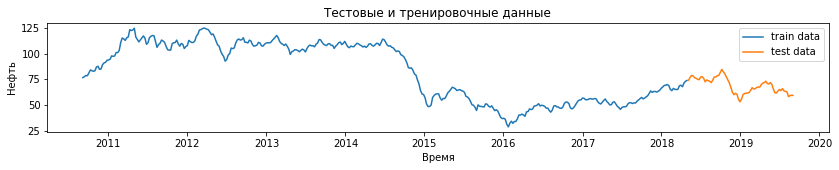

In [55]:
split_rate = 0.15 # Размер тестовой выборки, %

split_date = brent_data_w.index[(int(len(brent_data_w.index) * (1-split_rate)))]

train, test = split_data(brent_data_w, split_date)

plt.figure( figsize=(14, 2))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [57]:
X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

X_train_10 = X_10[:train.shape[0],:]
y_train_10 = y_10[:train.shape[0],0]
X_test_10 = X_10[train.shape[0]:,:]
y_test_10 = y_10[train.shape[0]:,0]

# X_train_10p5 = X_10p5[:train.shape[0],:]
# y_train_10p5 = y_10p5[:train.shape[0],0]
# X_test_10p5 = X_10p5[train.shape[0]:,:]
# y_test_10p5 = y_10p5[train.shape[0]:,0]

## Тестирование моделей из списка с глубиной прогнозирования h=1
 <left><a class="anchor" id="modelbuilding"></a><left>

Данные для временного ряда brent даже после ресемплинга имеют случайные биения и небольшой горизонт прогнозирования (h=1), на что различные модели могут реагировать по-разному, поэтому целесообразно использовать несколько моделей и сравнить результаты их работы

In [21]:
# Проверка предсказательной способности разных моделей

models = []
models.append(catb.CatBoostRegressor(silent=True, random_state=42))
models.append(GradientBoostingRegressor(max_depth=3,  n_estimators=300, random_state=42))
models.append(RandomForestRegressor(max_depth=5, min_samples_split=3, random_state=42))
models.append(LinearRegression())

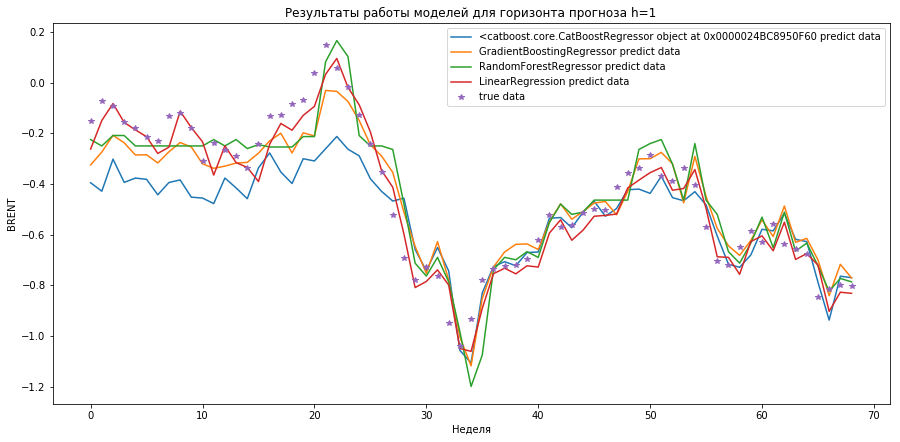

In [22]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Неделя')
plt.ylabel('BRENT')

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(y_pred, label='%s predict data' % (md))

plt.plot(y_test, '*', label='true data')
plt.title('Результаты работы моделей для горизонта прогноза h=1')

plt.legend()
plt.show()

Оценка метрик качества моделей

In [23]:
# Функционал ошибки MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Вывод метрик качества

def get_errors(y_test, y_test_pred_g, scl_target, h):
    
    er_g = mean_absolute_percentage_error(
    y_true=scl_target.inverse_transform(y_test),
    y_pred = scl_target.inverse_transform( y_test_pred_g)
    )

    er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
    print('Ошибка MSE :  ', er_s,'\nОшибка MAE  :  ', er_a,'\nОценка R2 :  ', er_r2,'\nОшибка MAPE :', round(er_g,2),'%\n')

In [24]:
print(f'{"*"*40}Оценка моделей с глубиной предсказания h=1:{"*"*40}\n\n')
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    md = str(model)
    md = md[:md.find('(')]
    print(f'{"*"*19} Оценка работы модели : {md} {"*"*19}\n')
    get_errors(y_test, y_pred, scl_target, h1)

****************************************Оценка моделей с глубиной предсказания h=1:****************************************


******************* Оценка работы модели : <catboost.core.CatBoostRegressor object at 0x0000024BC8950F60 *******************

Ошибка MSE :   0.025235563178595825 
Ошибка MAE  :   0.1236390268773968 
Оценка R2 :   0.6772973065743444 
Ошибка MAPE : 4.56 %

******************* Оценка работы модели : GradientBoostingRegressor *******************

Ошибка MSE :   0.010288945296396856 
Ошибка MAE  :   0.08435993656744227 
Оценка R2 :   0.8684289177079803 
Ошибка MAPE : 3.26 %

******************* Оценка работы модели : RandomForestRegressor *******************

Ошибка MSE :   0.011980698456092634 
Ошибка MAE  :   0.08673545933014243 
Оценка R2 :   0.8467954278040085 
Ошибка MAPE : 3.38 %

******************* Оценка работы модели : LinearRegression *******************

Ошибка MSE :   0.005092348184085691 
Ошибка MAE  :   0.05732390402508181 
Оценка R2 :   0.934881006489

Как результат, линейная регрессия, имеющая самый простой алгоритм из представленного списка моделей лучше других описывает текущие данные. Более низкое качество ансамблей может зависеть от глубины прогноза, а также отсутствия настройки моделей. Проведем аналогичную операцию для горизонта прогнозирования h=10 и сравним результаты

## Тест горизонта h=10
 <left><a class="anchor" id="h10"></a><left>

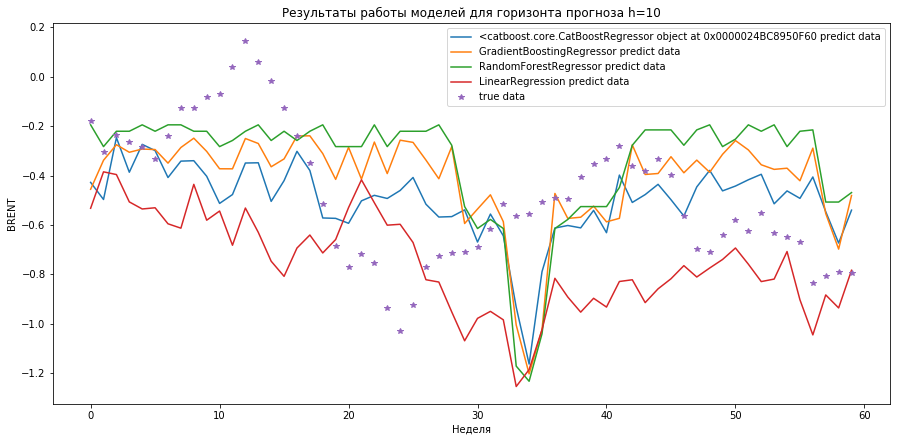

In [25]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Неделя')
plt.ylabel('BRENT')

for model in models:
    model.fit(X_train_10, y_train_10)
    y_pred = model.predict(X_test_10)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(y_pred, label='%s predict data' % (md))

plt.plot(y_test_10, '*', label='true data')
plt.title('Результаты работы моделей для горизонта прогноза h=10')

plt.legend()
plt.show()

In [26]:
print(f'{"*"*40}Оценка моделей с глубиной предсказания h=10:{"*"*40}\n\n')

for model in models:
    model.fit(X_train_10, y_train_10)
    y_pred = model.predict(X_test_10)
    md = str(model)
    md = md[:md.find('(')]
    print(f'{"*"*19} Оценка работы модели : {md} {"*"*19}\n')
    get_errors(y_test_10, y_pred, scl_target_10, h10)

****************************************Оценка моделей с глубиной предсказания h=10:****************************************


******************* Оценка работы модели : <catboost.core.CatBoostRegressor object at 0x0000024BC8950F60 *******************

Ошибка MSE :   0.07000812662522125 
Ошибка MAE  :   0.21860738493134627 
Оценка R2 :   0.04590042609310774 
Ошибка MAPE : 8.81 %

******************* Оценка работы модели : GradientBoostingRegressor *******************

Ошибка MSE :   0.09715706164444711 
Ошибка MAE  :   0.2561185142083245 
Оценка R2 :   -0.3240964383071676 
Ошибка MAPE : 10.65 %

******************* Оценка работы модели : RandomForestRegressor *******************

Ошибка MSE :   0.12503129251604875 
Ошибка MAE  :   0.2878937407093826 
Оценка R2 :   -0.7039779332077378 
Ошибка MAPE : 12.16 %

******************* Оценка работы модели : LinearRegression *******************

Ошибка MSE :   0.1526000069899771 
Ошибка MAE  :   0.3364175875802997 
Оценка R2 :   -1.079695724851

В результате увеличения глубины предсказания (h) до 10, рейтинг моделей по предсказательной точности практически инвертировался. Ошибка предсказания возрасла у всех моделей без исключения. Предсказания идут с лагом порядка 10 измерений, ошибка линейной регрессии возросла до 6 раз, модель cat boost показала лучший результат. В целом, увеличение глубины предсказания отрицательно сказывается на работоспособности модели для текущего датасета. Попробуем подобрать параметры и попробовать улучшить ситуацию, используем ту, что показала лучший результат.

## Пробуем улучшить модель
 <left><a class="anchor" id="mref"></a><left>

In [40]:
params = {'n_estimators':[50, 100, 200], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[ 0.01, 0.05, 0.07, 0.1]}

In [41]:
cv=KFold(n_splits=3, random_state=42, shuffle=False)

In [42]:
rs = RandomizedSearchCV(catb.CatBoostRegressor(), params, scoring='r2', cv=cv, n_jobs=-1)
rs.fit(X_train_10, y_train_10)

0:	learn: 1.0059086	total: 2.04ms	remaining: 405ms
1:	learn: 0.9674893	total: 3.63ms	remaining: 360ms
2:	learn: 0.9291988	total: 4.87ms	remaining: 320ms
3:	learn: 0.8929516	total: 6.05ms	remaining: 296ms
4:	learn: 0.8580091	total: 7.27ms	remaining: 284ms
5:	learn: 0.8223677	total: 8.45ms	remaining: 273ms
6:	learn: 0.7893801	total: 9.58ms	remaining: 264ms
7:	learn: 0.7567520	total: 10.7ms	remaining: 257ms
8:	learn: 0.7267559	total: 11.9ms	remaining: 252ms
9:	learn: 0.7005790	total: 13.1ms	remaining: 249ms
10:	learn: 0.6735962	total: 14.3ms	remaining: 245ms
11:	learn: 0.6491775	total: 15.5ms	remaining: 242ms
12:	learn: 0.6262549	total: 16.8ms	remaining: 241ms
13:	learn: 0.6039835	total: 18ms	remaining: 239ms
14:	learn: 0.5846250	total: 19.2ms	remaining: 237ms
15:	learn: 0.5651489	total: 20.4ms	remaining: 234ms
16:	learn: 0.5470044	total: 21.6ms	remaining: 232ms
17:	learn: 0.5310752	total: 22.7ms	remaining: 230ms
18:	learn: 0.5138235	total: 23.9ms	remaining: 228ms
19:	learn: 0.4967519	tot

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=<catboost.core.CatBoostRegressor object at 0x0000024BCAB28FD0>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.01, 0.05, 0.07, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=0)

In [43]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}

In [44]:
rs.best_score_

0.2880763177857727

In [51]:
# Данные с подобранными параметрами
cat_model_opt = catb.CatBoostRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, silent=True, random_state=42)
cat_model_opt.fit(X_train_10, y_train_10)
y_cat_pred = model.predict(X_test_10)

# Результат с базовыми параметрами для сравнения
model_ = models[0]
model_.fit(X_train_10, y_train_10)
y_cat_pred_ = model_.predict(X_test_10)

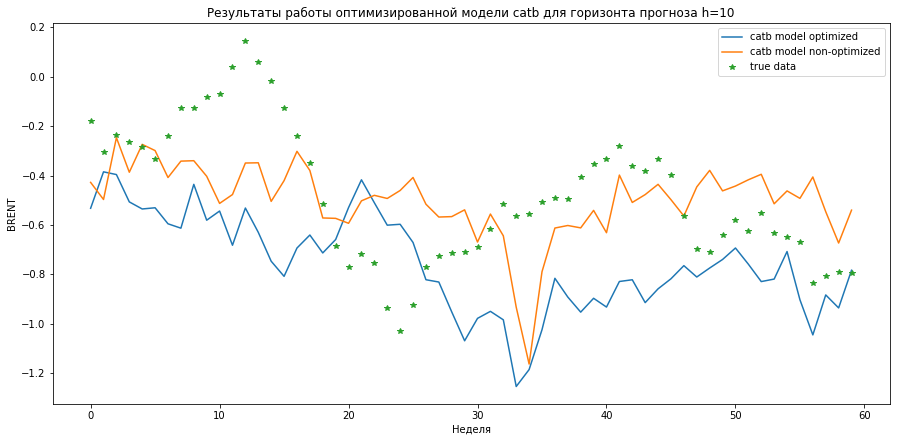

In [52]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Неделя')
plt.ylabel('BRENT')

plt.plot(y_cat_pred, label='catb model optimized')
plt.plot(y_cat_pred_, label='catb model non-optimized')
plt.plot(y_test_10, '*', label='true data')
plt.title('Результаты работы оптимизированной модели catb для горизонта прогноза h=10')

plt.legend()
plt.show()

In [49]:
get_errors(y_test_10, y_cat_pred, scl_target_10, h10)

Ошибка MSE :   0.1526000069899771 
Ошибка MAE  :   0.3364175875802997 
Оценка R2 :   -1.0796957248513692 
Ошибка MAPE : 13.01 %



- По итогу оптимизация модели не улучшила результаты прогноза, ошибка на тестовых данных возросла, использование любой из проанализированных моделей при h=10 (и выше) не принесет достоверных результатов.
- Увеличение глубины прогноза также ведет к накоплению ошибки
- Основной проблемой является особенность ряда Brent, характеризующийся отсутствием сезонности и изобилием случайных биений.
- Тем не менее, предсказание с достаточно хорошей дочностью возможно путем прямого прогнозирования, или прогнозирования с малым шагом